In [9]:
#visualize
import numpy as np 
import matplotlib.pyplot as plt # to visualize only  
import os
from six.moves import urllib

URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"
PATH = "dataset"

def fetch_data(name, url, path):
    if not os.path.isdir(path):
        os.makedirs(path)
    l_path = os.path.join(path, name)
    urllib.request.urlretrieve(url, l_path)

fetch_data("train_x.csv", URL_ENDPOINT+"train_x.csv", PATH)
fetch_data("train_y.csv", URL_ENDPOINT+"train_y.csv", PATH)
fetch_data("test_x.csv", URL_ENDPOINT+"test_x.csv", PATH)

x = np.loadtxt("dataset/train_x.csv", delimiter=",")
y = np.loadtxt("dataset/train_y.csv", delimiter=",")
x_test = np.loadtxt("dataset/test_x.csv", delimiter=",")

x = x.reshape(-1, 64, 64) # reshape 
y = y.reshape(-1, 1)
x_test = x_test.reshape(-1, 64, 64)

# Preprocessing Data

In [10]:
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
from skimage.segmentation import clear_border
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.color import rgb2gray

def preproc(x,shape):
    standard = shape
    resized = np.zeros(shape=(x.shape[0],standard,standard))

    for n in range(x.shape[0]):


        # apply threshold
        #thresh = threshold_mean(x[n])
        t = np.array(x[n])
        t[t != 255] = 0
        t[t == 255] = 1
        bw = t # >= thresh

        label_image = label(bw)
        num = 0
        max_region = regionprops(label_image)

        for region in regionprops(label_image):


            r0,c0,r1,c1 = region.bbox
            length = max(abs(r0-r1),abs(c0-c1))

            if length > num:
                num = length
                max_region = region

        # crop largest segment
        r0, c0, r1, c1 = max_region['BoundingBox']
        cropped = bw[min(r0,r1):max(r0,r1), min(c0,c1):max(c0,c1)]
        
        # resize to standardized size
        resized[n] = resize(cropped, (standard,standard))
        if n%5000 == 0:
            print("On #: ", n)

    return resized

In [13]:
# run preproc
shape=28
re_x = preproc(x,shape)
print("Training preprocessing done!")
re_xtest = preproc(x_test,shape)
print("Testing preprocessing done!")

C:\Users\BHYUNG\Anaconda3\envs\ml\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


On #:  0
On #:  5000
On #:  10000
On #:  15000
On #:  20000
On #:  25000
On #:  30000
On #:  35000
On #:  40000
On #:  45000
Training preprocessing done!
On #:  0
On #:  5000
Testing preprocessing done!


In [14]:
# increase training data through flips
def flip(x,y):
    flippedx = np.array(x)
    flippedy = np.array(y)
    size = 50000

    for i in range(size):
        if i%5000 == 0:
                print(i)
                
        if int(y[i]) == 1 or int(y[i]) == 8 or int(y[i]) == 0:
            new = np.array(np.fliplr(x[i]))
            flippedx = np.append(flippedx,new)
            flippedy = np.append(flippedy,y[i])
            
    return flippedx, flippedy

In [15]:
from random import randint
from skimage.transform import rotate

def rotateim(x,y):
    rotatex = np.array(x)
    rotatey = np.array(y)
    size = 50000
    
    for i in range(size):
        if i%100 == 0:
                print(i)
        
        deg = randint(-15,15)

        new = np.array(rotate(x[i],deg))
        rotatex = np.append(rotatex,new)
        rotatey = np.append(rotatey,y[i])
            
    return rotatex, rotatey

In [16]:
# image augmentation  
# not fully run for this notebook, but was run for Kaggle + other models
re_x, y = rotateim(re_x,y)
re_x, y = flip(re_x,y)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600


KeyboardInterrupt: 

In [17]:
# reshape data
re_x = re_x.reshape(-1,shape**2)
y = y.squeeze()
re_xtest = re_xtest.reshape(-1,shape**2)

# 80-20 split
x_train=re_x
y_train=y
x_test=re_xtest
 
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y,test_size=0.2, random_state=42)

In [18]:
# save predictions
import pandas as pd
from IPython.display import display, HTML

def sav(y,name):
    f = open("predictions/"+name,"w",encoding='utf-8')
    f.write("Id,Label\n")
    for i in range(10000):
        f.write(str(i)+","+str(int(y[i]))+"\n")
        
    f.close()

# Question 1

In [19]:
# Linear SVM w/ sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


c = [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.9]
t_results = []
v_results = []
for i in range(len(c)):
    print("On C: ", c[i])
    clf = LinearSVC(C=c[i],random_state=0, loss='hinge', multi_class='ovr',max_iter=1000)
    clf.fit(x_train,y_train)

    y_pred_train = clf.predict(x_train)
    y_pred_valid = clf.predict(x_valid)
    y_pred_test = clf.predict(x_test)
    
    t_results.append(accuracy_score(y_train,y_pred_train))
    v_results.append(accuracy_score(y_valid,y_pred_valid))
    
    print("Training score: ", accuracy_score(y_train,y_pred_train))
    print("Validation score: ", accuracy_score(y_valid,y_pred_valid))
    
    sav(y_pred_test,"linsvm_"+str(c[i])+".csv")

On C:  0.001
Training score:  0.73105
Validation score:  0.7154
On C:  0.01
Training score:  0.765775
Validation score:  0.743
On C:  0.1
Training score:  0.79465
Validation score:  0.7542
On C:  0.2
Training score:  0.796275
Validation score:  0.7516
On C:  0.4
Training score:  0.797275
Validation score:  0.7513
On C:  0.6
Training score:  0.79865
Validation score:  0.7518
On C:  0.9
Training score:  0.7984
Validation score:  0.7506


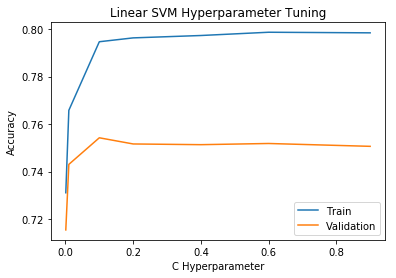

In [31]:
# plot training vs. validation
plt.plot(c, t_results, label='Train')
plt.plot(c, v_results, label='Validation')
plt.xlabel('C Hyperparameter')
plt.ylabel('Accuracy')
plt.title('Linear SVM Hyperparameter Tuning')
plt.legend()

plt.savefig('svm_tuning.png')
plt.show()

In [21]:
# optimized C hyperparameter
opt_c = v_results.index(max(v_results))
print("Optimal C:", c[opt_c])

Optimal C: 0.1


# Question 2 - Neural Net

In [29]:
import numpy as np
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.transform import resize

def loadData(shape):
    x = np.loadtxt("train_x.csv", delimiter=",") # load from text 
    y = np.loadtxt("train_y.csv", delimiter=",") 
    x_test = np.loadtxt("test_x.csv", delimiter=",")
    x = x.reshape(-1, 64, 64) # reshape 
    y = y.reshape(-1, 1)
    x = preProcess(x,shape)
    x = x.reshape((50000, shape**2))
    y = y.reshape(50000)
    return x,y, x_test

def preProcess(x,shape): 
    resized = np.zeros(shape=(x.shape[0],shape,shape))
    for n in range(x.shape[0]):
        t = np.array(x[n])
        t[t != 255] = 0
        t[t == 255] = 1
        label_image = label(t)
        num = 0
        max_region = regionprops(label_image)
        for region in regionprops(label_image):
            r0,c0,r1,c1 = region.bbox
            length = max(abs(r0-r1),abs(c0-c1))
            if length > num:
                num = length
                max_region = region
        r0, c0, r1, c1 = max_region['BoundingBox']
        cropped = t[min(r0,r1):max(r0,r1), min(c0,c1):max(c0,c1)]
        resized[n] = resize(cropped, (shape,shape))
        if n%5000 == 0:
            print("On #: ", n)
    return resized

def encode_labels(y, outputs):
    output = np.zeros(shape = (y.shape[0],outputs))
    for i in range(y.shape[0]):
        output[i, int(y[i]) ] = 1.0
    return output

def convertResult(x):
    output = np.zeros(shape = (10))
    t = np.argmax(x)
    output[t] = 1
    return output

def getData(Classes, shape):
    x,y, x_test = loadData(shape)
    y = encode_labels(y,Classes)
    split = int(x.shape[0] * .8)
    x_test = x[split:,:]
    y_test = y[split:,:]
    x_train = x[:split,:]
    y_train = y[:split,:]
    return x_train, y_train, x_test, y_test

def writeErrorCSV(name, error):
    with open(name, 'w') as a:
            for line in error:
                temp = np.array2string(line)
                a.write(temp)
                a.write("\n")

def testResult(x_test, y_test,w1,w2,b1,b2):
    active = relu_activation(np.dot(x_test, w1) + b1)
    scores = np.dot(active, w2) + b2
    probs = softmax(scores) 
    loss = cross_entropy_softmax_loss_array(probs, y_test)
    return loss

def initializeValues(inputs, hidden_nodes, outputs):
    w1 = np.random.normal(0, 1, [inputs, hidden_nodes])
    w2 = np.random.normal(0, 1, [hidden_nodes, outputs]) 
    b1 = np.zeros((1, hidden_nodes))
    b2 = np.zeros((1, outputs))
    return w1, w2, b1, b2             

def relu_activation(data_array):
    return np.maximum(data_array, 0)

def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)



def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

def regularization_L2_softmax_loss(r_lambda, weight1, weight2):
    weight1_loss = 0.5 * r_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * r_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss

def feedForward(w1,w2,b1,b2,x_train):
    input_layer = np.dot(x_train, w1)
    hidden_layer = relu_activation(input_layer + b1)
    output_layer = np.dot(hidden_layer, w2) + b2
    output_probs = softmax(output_layer)
    return input_layer, hidden_layer, output_layer, output_probs

def errorRate(w1, w2, r_lambda,output_probs, y_train, hidden_layer):
    loss = cross_entropy_softmax_loss_array(output_probs, y_train)
    loss += regularization_L2_softmax_loss(r_lambda, w1, w2)
    output_error_signal = (output_probs - y_train) / output_probs.shape[0]
    error_signal_hidden = np.dot(output_error_signal, w2.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    return loss, output_error_signal, error_signal_hidden

def feedBack(x_train,w1,w2, b1,b2, hidden_layer, output_error_signal, error_signal_hidden, r_lambda, learning_rate):
    gw1 = np.dot(x_train.T, error_signal_hidden)
    gw2 = np.dot(hidden_layer.T, output_error_signal)
    gb1 = np.sum(error_signal_hidden, axis = 0, keepdims = True)
    gb2 = np.sum(output_error_signal, axis = 0, keepdims = True)
    gw1 += r_lambda * w1                      
    gw2 += r_lambda * w2
    w1 -= learning_rate * gw1
    w2 -= learning_rate * gw2
    b1 -= learning_rate * gb1
    b2 -= learning_rate * gb2
    return w1, w2, b1, b2

def main():
    #Constants
    nodes = 5
    learning_rate = .001
    r_lambda = .01
    error = []
    test = []
    epoch = 50000
    #Initialization
    x_train, y_train, x_test, y_test = getData(10, 28)
    w1, w2, b1, b2 = initializeValues(28**2, nodes, 10)
    #BackPropagation
    for step in range(epoch):
        #feedForward
        input_layer, hidden_layer, output_layer, output_probs = feedForward(w1,w2,b1,b2,x_train)
        #Error Calculation        
        loss, output_error_signal, error_signal_hidden = errorRate(w1, w2, r_lambda,output_probs, y_train, hidden_layer)
        #FeedBack
        w1, w2, b1, b2 = feedBack(x_train,w1,w2, b1,b2, hidden_layer, output_error_signal, error_signal_hidden, r_lambda, learning_rate)
        error.append(loss)
        print ('Train Loss {0}: {1}'.format(step, loss))
        test.append(testResult(x_test, y_test,w1,w2,b1,b2))
    writeErrorCSV("Trainloss.csv", error)
    writeErrorCSV("Testloss.csv", test)


#Initialization
x_train, y_train, x_test, y_test = getData(10, 28)
nodes = 5
learning_rates = [1/i for i in range(1,11)]
r_lambda = .01
error = []
test = []
epoch = 10
w1, w2, b1, b2 = initializeValues(28**2, nodes, 10)
#BackPropagation
learning_rate = learning_rates[0]
for step in range(epoch):
    #feedForward
    input_layer, hidden_layer, output_layer, output_probs = feedForward(w1,w2,b1,b2,x_train)
    #Error Calculation        
    loss, output_error_signal, error_signal_hidden = errorRate(w1, w2, r_lambda,output_probs, y_train, hidden_layer)
    #FeedBack
    w1, w2, b1, b2 = feedBack(x_train,w1,w2, b1,b2, hidden_layer, output_error_signal, error_signal_hidden, r_lambda, learning_rate)
    error.append(loss)
    print ('Train Loss {0}: {1}'.format(step, loss))
    testError = testResult(x_test, y_test,w1,w2,b1,b2)
    print(testError)
    test.append(testError)
print(test)
writeErrorCSV("Trainloss.csv", error)
writeErrorCSV("Testloss.csv", test)
main()

C:\Users\BHYUNG\Anaconda3\envs\ml\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


On #:  0
On #:  5000
On #:  10000
On #:  15000
On #:  20000
On #:  25000
On #:  30000
On #:  35000
On #:  40000
On #:  45000
Train Loss 0: 65.97617184493235
Train Loss 1: 65.3261611846257
Train Loss 2: 64.69495166447393
Train Loss 3: 64.08175327077946
Train Loss 4: 63.485635329750515
Train Loss 5: 62.9056019142753
Train Loss 6: 62.340766384182984
Train Loss 7: 61.79064863907992
Train Loss 8: 61.25403228237144
Train Loss 9: 60.73043625875607
Train Loss 10: 60.219737580334694
Train Loss 11: 59.721428778242206
Train Loss 12: 59.23446149371564
Train Loss 13: 58.75900993076232
Train Loss 14: 58.29436920494129
Train Loss 15: 57.840037531839236
Train Loss 16: 57.395682752655986
Train Loss 17: 56.960611547447186
Train Loss 18: 56.534492013924094
Train Loss 19: 56.11699523013917
Train Loss 20: 55.70791422096549
Train Loss 21: 55.30696420258457
Train Loss 22: 54.91347743788435
Train Loss 23: 54.52759929452777
Train Loss 24: 54.149267413020084
Train Loss 25: 53.77800333818808
Train Loss 26: 53.41

Train Loss 240: 26.72737405265734
Train Loss 241: 26.693499355229783
Train Loss 242: 26.659955464791814
Train Loss 243: 26.626727152022724
Train Loss 244: 26.593801899895016
Train Loss 245: 26.56115587235815
Train Loss 246: 26.528849270002112
Train Loss 247: 26.49691526942189
Train Loss 248: 26.465263113654075
Train Loss 249: 26.433889240782953
Train Loss 250: 26.402785516981506
Train Loss 251: 26.371965890803473
Train Loss 252: 26.341431427695603
Train Loss 253: 26.31121302380256
Train Loss 254: 26.281274142458876
Train Loss 255: 26.251586451102714
Train Loss 256: 26.22219400876947
Train Loss 257: 26.19305069663968
Train Loss 258: 26.16415066006189
Train Loss 259: 26.13547766226
Train Loss 260: 26.107068067332886
Train Loss 261: 26.078910128589662
Train Loss 262: 26.050967117960894
Train Loss 263: 26.02325292113555
Train Loss 264: 25.995808224393382
Train Loss 265: 25.96863531081207
Train Loss 266: 25.941714318996137
Train Loss 267: 25.915006368561258
Train Loss 268: 25.88854546555855

Train Loss 478: 23.242222106708596
Train Loss 479: 23.236837914447324
Train Loss 480: 23.231493558517517
Train Loss 481: 23.22618771120038
Train Loss 482: 23.220913173756454
Train Loss 483: 23.215671508154184
Train Loss 484: 23.210467499631356
Train Loss 485: 23.205295657829193
Train Loss 486: 23.200160661641867
Train Loss 487: 23.195056236680465
Train Loss 488: 23.189969923594653
Train Loss 489: 23.184911116187553
Train Loss 490: 23.17988513646084
Train Loss 491: 23.17488489935758
Train Loss 492: 23.169917190930903
Train Loss 493: 23.164978555255512
Train Loss 494: 23.16007066754091
Train Loss 495: 23.155192927620707
Train Loss 496: 23.15034262873428
Train Loss 497: 23.14551664222863
Train Loss 498: 23.140721984425127
Train Loss 499: 23.135958936039064
Train Loss 500: 23.131225515854407
Train Loss 501: 23.126521811129614
Train Loss 502: 23.121839900876665
Train Loss 503: 23.11718194824738
Train Loss 504: 23.112553834673577
Train Loss 505: 23.107949691921714
Train Loss 506: 23.10337151

Train Loss 716: 22.495291003274474
Train Loss 717: 22.49341749626779
Train Loss 718: 22.491550563178752
Train Loss 719: 22.489690751811395
Train Loss 720: 22.48783824789645
Train Loss 721: 22.485991227215386
Train Loss 722: 22.484148937354746
Train Loss 723: 22.48230990358425
Train Loss 724: 22.480475834601236
Train Loss 725: 22.478651038820438
Train Loss 726: 22.47683112680867
Train Loss 727: 22.475018292872075
Train Loss 728: 22.473211009932243
Train Loss 729: 22.471406058233335
Train Loss 730: 22.469605818366038
Train Loss 731: 22.467810509591764
Train Loss 732: 22.466021153344744
Train Loss 733: 22.46423838568295
Train Loss 734: 22.462459594043427
Train Loss 735: 22.46068610017861
Train Loss 736: 22.458917697764264
Train Loss 737: 22.457156057751515
Train Loss 738: 22.455400621332764
Train Loss 739: 22.453653164496018
Train Loss 740: 22.45191379916399
Train Loss 741: 22.45018205963738
Train Loss 742: 22.448456662371775
Train Loss 743: 22.44673644020932
Train Loss 744: 22.4450221969

Train Loss 953: 22.1739349804442
Train Loss 954: 22.172922451277966
Train Loss 955: 22.171911643802098
Train Loss 956: 22.170901899284875
Train Loss 957: 22.169893689828207
Train Loss 958: 22.16888937649596
Train Loss 959: 22.167887002361915
Train Loss 960: 22.16688575584056
Train Loss 961: 22.16588528772536
Train Loss 962: 22.164886690315925
Train Loss 963: 22.1638897403622
Train Loss 964: 22.162894673194153
Train Loss 965: 22.161902982319845
Train Loss 966: 22.160913465745878
Train Loss 967: 22.159925978821907
Train Loss 968: 22.158940168323085
Train Loss 969: 22.1579553703723
Train Loss 970: 22.156972353359983
Train Loss 971: 22.15599181103322
Train Loss 972: 22.15501355082939
Train Loss 973: 22.15403749743698
Train Loss 974: 22.1530628698938
Train Loss 975: 22.15209043821417
Train Loss 976: 22.151119465636903
Train Loss 977: 22.150151059840603
Train Loss 978: 22.14918319092461
Train Loss 979: 22.148216265024235
Train Loss 980: 22.147249605696658
Train Loss 981: 22.14628439086153
Tr

Train Loss 1186: 21.975205689353093
Train Loss 1187: 21.974474978841403
Train Loss 1188: 21.97374450395941
Train Loss 1189: 21.973014364510835
Train Loss 1190: 21.97228470190925
Train Loss 1191: 21.9715557030784
Train Loss 1192: 21.970827380963964
Train Loss 1193: 21.970099481888788
Train Loss 1194: 21.969372132704137
Train Loss 1195: 21.9686455788341
Train Loss 1196: 21.967920047317435
Train Loss 1197: 21.967195653911546
Train Loss 1198: 21.966471713221942
Train Loss 1199: 21.965748394422484
Train Loss 1200: 21.96502588229835
Train Loss 1201: 21.964304177629575
Train Loss 1202: 21.963583143404676
Train Loss 1203: 21.962862853245298
Train Loss 1204: 21.962143364887382
Train Loss 1205: 21.961424613632992
Train Loss 1206: 21.960706645932362
Train Loss 1207: 21.959989408729665
Train Loss 1208: 21.959272348171606
Train Loss 1209: 21.95855537182467
Train Loss 1210: 21.95783872138765
Train Loss 1211: 21.957122726325892
Train Loss 1212: 21.95640709912457
Train Loss 1213: 21.95569211011305
Tra

Train Loss 1417: 21.821825022772796
Train Loss 1418: 21.821222256440606
Train Loss 1419: 21.820619867356875
Train Loss 1420: 21.820017801822146
Train Loss 1421: 21.819415394735362
Train Loss 1422: 21.818813409377963
Train Loss 1423: 21.8182118055783
Train Loss 1424: 21.81761053195207
Train Loss 1425: 21.81700980243038
Train Loss 1426: 21.8164095178974
Train Loss 1427: 21.81580963593127
Train Loss 1428: 21.815209942880706
Train Loss 1429: 21.814610744573983
Train Loss 1430: 21.81401165456281
Train Loss 1431: 21.813412774257372
Train Loss 1432: 21.812814278770364
Train Loss 1433: 21.812216244014778
Train Loss 1434: 21.811618852435828
Train Loss 1435: 21.811021903501825
Train Loss 1436: 21.81042544542887
Train Loss 1437: 21.80982930310538
Train Loss 1438: 21.809233402852847
Train Loss 1439: 21.808637758594667
Train Loss 1440: 21.80804233627313
Train Loss 1441: 21.80744707340116
Train Loss 1442: 21.806851901866747
Train Loss 1443: 21.806257056094644
Train Loss 1444: 21.805662606697965
Trai

Train Loss 1650: 21.689568581480717
Train Loss 1651: 21.68903237880117
Train Loss 1652: 21.68849638852886
Train Loss 1653: 21.687960593361048
Train Loss 1654: 21.687425044727316
Train Loss 1655: 21.68688970947642
Train Loss 1656: 21.68635463479947
Train Loss 1657: 21.685819925027232
Train Loss 1658: 21.685285461016324
Train Loss 1659: 21.684751114457285
Train Loss 1660: 21.684216734581195
Train Loss 1661: 21.683682495938644
Train Loss 1662: 21.683148412073837
Train Loss 1663: 21.682614253658876
Train Loss 1664: 21.682080318975974
Train Loss 1665: 21.681546738231493
Train Loss 1666: 21.681013469465505
Train Loss 1667: 21.680480390888224
Train Loss 1668: 21.679947476721214
Train Loss 1669: 21.679414708805854
Train Loss 1670: 21.678882051858388
Train Loss 1671: 21.67834962345161
Train Loss 1672: 21.677817356813083
Train Loss 1673: 21.677285198929876
Train Loss 1674: 21.676753236766675
Train Loss 1675: 21.676221562874137
Train Loss 1676: 21.675690054519922
Train Loss 1677: 21.6751587996824

Train Loss 1883: 21.56993504492904
Train Loss 1884: 21.569441954706885
Train Loss 1885: 21.568949075565065
Train Loss 1886: 21.568456481609466
Train Loss 1887: 21.567964060785513
Train Loss 1888: 21.567471810091057
Train Loss 1889: 21.566979707270985
Train Loss 1890: 21.56648772578098
Train Loss 1891: 21.56599582040019
Train Loss 1892: 21.565504059812827
Train Loss 1893: 21.5650125402244
Train Loss 1894: 21.564521285808702
Train Loss 1895: 21.564030152125444
Train Loss 1896: 21.563539055234116
Train Loss 1897: 21.56304812339146
Train Loss 1898: 21.562557418847774
Train Loss 1899: 21.562067144732584
Train Loss 1900: 21.56157692902925
Train Loss 1901: 21.561086820008143
Train Loss 1902: 21.560596965436332
Train Loss 1903: 21.560107109657377
Train Loss 1904: 21.559617165106424
Train Loss 1905: 21.559127312209966
Train Loss 1906: 21.55863771016583
Train Loss 1907: 21.558148258170252
Train Loss 1908: 21.557658853263764
Train Loss 1909: 21.557169731339425
Train Loss 1910: 21.556680592250153


Train Loss 2116: 21.458843188820655
Train Loss 2117: 21.45838039499253
Train Loss 2118: 21.457917859616476
Train Loss 2119: 21.457455441864983
Train Loss 2120: 21.456993121736545
Train Loss 2121: 21.45653074135858
Train Loss 2122: 21.456068484709416
Train Loss 2123: 21.455606334195952
Train Loss 2124: 21.45514426632256
Train Loss 2125: 21.454682273710105
Train Loss 2126: 21.4542204235663
Train Loss 2127: 21.453758709561686
Train Loss 2128: 21.4532970751173
Train Loss 2129: 21.452835541149565
Train Loss 2130: 21.452374070333303
Train Loss 2131: 21.45191257710802
Train Loss 2132: 21.451451053769222
Train Loss 2133: 21.45098959965373
Train Loss 2134: 21.450528234912326
Train Loss 2135: 21.450066926453573
Train Loss 2136: 21.449605598275124
Train Loss 2137: 21.449144333500364
Train Loss 2138: 21.448683100288513
Train Loss 2139: 21.448221963994698
Train Loss 2140: 21.447760831890278
Train Loss 2141: 21.447299725427662
Train Loss 2142: 21.446838682721435
Train Loss 2143: 21.44637776538381
Tr

Train Loss 2346: 21.35448627741701
Train Loss 2347: 21.354041142850082
Train Loss 2348: 21.353595962119893
Train Loss 2349: 21.353150844599067
Train Loss 2350: 21.3527059384668
Train Loss 2351: 21.35226126012676
Train Loss 2352: 21.35181660588048
Train Loss 2353: 21.351371984109537
Train Loss 2354: 21.35092743335715
Train Loss 2355: 21.350482993601414
Train Loss 2356: 21.35003880207494
Train Loss 2357: 21.34959479837471
Train Loss 2358: 21.3491508310551
Train Loss 2359: 21.34870688568466
Train Loss 2360: 21.348262988180245
Train Loss 2361: 21.347819167126033
Train Loss 2362: 21.347375324372166
Train Loss 2363: 21.346931698544115
Train Loss 2364: 21.346488324845634
Train Loss 2365: 21.346045113497173
Train Loss 2366: 21.34560214003319
Train Loss 2367: 21.34515930549302
Train Loss 2368: 21.344716554534077
Train Loss 2369: 21.344273834883353
Train Loss 2370: 21.3438311129498
Train Loss 2371: 21.343388454000447
Train Loss 2372: 21.342945852289567
Train Loss 2373: 21.34250328487564
Train Lo

Train Loss 2576: 21.25403243857394
Train Loss 2577: 21.253603112876075
Train Loss 2578: 21.25317384051129
Train Loss 2579: 21.25274463474009
Train Loss 2580: 21.25231552429058
Train Loss 2581: 21.251886462457126
Train Loss 2582: 21.251457465595195
Train Loss 2583: 21.25102853800465
Train Loss 2584: 21.25059969785429
Train Loss 2585: 21.250170895255913
Train Loss 2586: 21.24974213168529
Train Loss 2587: 21.249313427722385
Train Loss 2588: 21.248884801179354
Train Loss 2589: 21.248456282103557
Train Loss 2590: 21.24802781876054
Train Loss 2591: 21.247599396032985
Train Loss 2592: 21.247171017142108
Train Loss 2593: 21.246742686875763
Train Loss 2594: 21.246314356194105
Train Loss 2595: 21.24588606660549
Train Loss 2596: 21.245457723960094
Train Loss 2597: 21.24502944183788
Train Loss 2598: 21.244601201797465
Train Loss 2599: 21.244172997734797
Train Loss 2600: 21.243744769578772
Train Loss 2601: 21.243316605562526
Train Loss 2602: 21.24288850563453
Train Loss 2603: 21.24246046974319
Trai

Train Loss 2809: 21.155308665287116
Train Loss 2810: 21.154890160851185
Train Loss 2811: 21.15447170799819
Train Loss 2812: 21.15405330668825
Train Loss 2813: 21.153634933177607
Train Loss 2814: 21.153216540018562
Train Loss 2815: 21.15279819842036
Train Loss 2816: 21.15237989099411
Train Loss 2817: 21.151961566489774
Train Loss 2818: 21.15154328022613
Train Loss 2819: 21.15112497966446
Train Loss 2820: 21.1507067078966
Train Loss 2821: 21.150288572855366
Train Loss 2822: 21.14987058426012
Train Loss 2823: 21.149452646724082
Train Loss 2824: 21.149034755409033
Train Loss 2825: 21.148616922756503
Train Loss 2826: 21.148199127682354
Train Loss 2827: 21.147781378113937
Train Loss 2828: 21.14736369989941
Train Loss 2829: 21.14694611578596
Train Loss 2830: 21.146528582077604
Train Loss 2831: 21.1461110820274
Train Loss 2832: 21.145693586098176
Train Loss 2833: 21.145276139121055
Train Loss 2834: 21.144858755705712
Train Loss 2835: 21.144441485753823
Train Loss 2836: 21.1440242469032
Train L

Train Loss 3042: 21.058805486317667
Train Loss 3043: 21.058395722265576
Train Loss 3044: 21.057985964371483
Train Loss 3045: 21.057576241806938
Train Loss 3046: 21.057166568964522
Train Loss 3047: 21.056756943259142
Train Loss 3048: 21.056347390233334
Train Loss 3049: 21.055937878154374
Train Loss 3050: 21.055528400726352
Train Loss 3051: 21.055118964872705
Train Loss 3052: 21.05470955287008
Train Loss 3053: 21.054300133062156
Train Loss 3054: 21.05389074196229
Train Loss 3055: 21.053481389576163
Train Loss 3056: 21.053072049715123
Train Loss 3057: 21.052662775663535
Train Loss 3058: 21.05225353566082
Train Loss 3059: 21.051844327136212
Train Loss 3060: 21.05143515902243
Train Loss 3061: 21.051026029286156
Train Loss 3062: 21.05061686576199
Train Loss 3063: 21.05020773446583
Train Loss 3064: 21.04979863185418
Train Loss 3065: 21.04938956209157
Train Loss 3066: 21.048980533317653
Train Loss 3067: 21.048571571722572
Train Loss 3068: 21.04816264519249
Train Loss 3069: 21.04775373748253
Tr

Train Loss 3273: 20.964905049685207
Train Loss 3274: 20.964502716580903
Train Loss 3275: 20.964100413550774
Train Loss 3276: 20.963698129923557
Train Loss 3277: 20.963295875377476
Train Loss 3278: 20.962893642670934
Train Loss 3279: 20.962491422525055
Train Loss 3280: 20.962089214580686
Train Loss 3281: 20.96168703876232
Train Loss 3282: 20.96128487515088
Train Loss 3283: 20.960882729998136
Train Loss 3284: 20.960480579580885
Train Loss 3285: 20.960078453723167
Train Loss 3286: 20.959676359534118
Train Loss 3287: 20.95927428690835
Train Loss 3288: 20.958872243789024
Train Loss 3289: 20.958470222985177
Train Loss 3290: 20.95806828055325
Train Loss 3291: 20.957666370791344
Train Loss 3292: 20.957264493497735
Train Loss 3293: 20.95686263140307
Train Loss 3294: 20.956460742119052
Train Loss 3295: 20.956058885498127
Train Loss 3296: 20.955657058178996
Train Loss 3297: 20.95525523426356
Train Loss 3298: 20.954853434349822
Train Loss 3299: 20.9544516629596
Train Loss 3300: 20.95404991714747
T

Train Loss 3505: 20.872260585182342
Train Loss 3506: 20.871864117780174
Train Loss 3507: 20.87146767099685
Train Loss 3508: 20.871071250791964
Train Loss 3509: 20.870674858742785
Train Loss 3510: 20.87027849483269
Train Loss 3511: 20.86988215904506
Train Loss 3512: 20.869485851363255
Train Loss 3513: 20.869089566025888
Train Loss 3514: 20.86869330245594
Train Loss 3515: 20.868297066955968
Train Loss 3516: 20.867900856251342
Train Loss 3517: 20.867504667117153
Train Loss 3518: 20.867108514514563
Train Loss 3519: 20.866712342417937
Train Loss 3520: 20.866316188784957
Train Loss 3521: 20.865920067179516
Train Loss 3522: 20.86552399020067
Train Loss 3523: 20.86512792779966
Train Loss 3524: 20.86473188739007
Train Loss 3525: 20.86433589791068
Train Loss 3526: 20.86393986682224
Train Loss 3527: 20.863543868341022
Train Loss 3528: 20.863147896915738
Train Loss 3529: 20.86275192831892
Train Loss 3530: 20.86235594231379
Train Loss 3531: 20.861959984038513
Train Loss 3532: 20.861564017841594
Tra

Train Loss 3738: 20.780504587012487
Train Loss 3739: 20.780113538670054
Train Loss 3740: 20.779722525635577
Train Loss 3741: 20.779331556588698
Train Loss 3742: 20.778940605888987
Train Loss 3743: 20.778549678760825
Train Loss 3744: 20.778158775192068
Train Loss 3745: 20.777767895170577
Train Loss 3746: 20.77737703868421
Train Loss 3747: 20.776986205720835
Train Loss 3748: 20.776595434691487
Train Loss 3749: 20.776204820005287
Train Loss 3750: 20.775814228199955
Train Loss 3751: 20.77542363327172
Train Loss 3752: 20.77503303207506
Train Loss 3753: 20.774642453562127
Train Loss 3754: 20.774251887661023
Train Loss 3755: 20.773861345060034
Train Loss 3756: 20.773470825746976
Train Loss 3757: 20.773080329709657
Train Loss 3758: 20.77268985693591
Train Loss 3759: 20.772299407282112
Train Loss 3760: 20.77190898230927
Train Loss 3761: 20.77151858786891
Train Loss 3762: 20.771128208296638
Train Loss 3763: 20.770737843688384
Train Loss 3764: 20.770347502686604
Train Loss 3765: 20.76995718724886

Train Loss 3969: 20.69069174700568
Train Loss 3970: 20.69030506970494
Train Loss 3971: 20.689918413091778
Train Loss 3972: 20.689531778970654
Train Loss 3973: 20.68914521160803
Train Loss 3974: 20.68875866480334
Train Loss 3975: 20.688372138547372
Train Loss 3976: 20.687985631027978
Train Loss 3977: 20.687599131049698
Train Loss 3978: 20.68721261431508
Train Loss 3979: 20.68682611244436
Train Loss 3980: 20.68643959437022
Train Loss 3981: 20.686053079162104
Train Loss 3982: 20.685666584517133
Train Loss 3983: 20.6852801104262
Train Loss 3984: 20.68489365688019
Train Loss 3985: 20.684507223556373
Train Loss 3986: 20.684120805978612
Train Loss 3987: 20.683734408205677
Train Loss 3988: 20.68334802474758
Train Loss 3989: 20.68296166361595
Train Loss 3990: 20.682575325557718
Train Loss 3991: 20.682189007988605
Train Loss 3992: 20.68180270335142
Train Loss 3993: 20.681416400799662
Train Loss 3994: 20.68103010525779
Train Loss 3995: 20.680643809648167
Train Loss 3996: 20.680257534495745
Train 

Train Loss 4200: 20.60185949696498
Train Loss 4201: 20.601477109046616
Train Loss 4202: 20.60109473523579
Train Loss 4203: 20.60071237963517
Train Loss 4204: 20.600330042236983
Train Loss 4205: 20.599947722940186
Train Loss 4206: 20.599565411034224
Train Loss 4207: 20.599183109024843
Train Loss 4208: 20.598800808812673
Train Loss 4209: 20.598418526841165
Train Loss 4210: 20.598036263102454
Train Loss 4211: 20.59765401758872
Train Loss 4212: 20.59727178829144
Train Loss 4213: 20.59688956885801
Train Loss 4214: 20.59650736762876
Train Loss 4215: 20.59612518459587
Train Loss 4216: 20.59574301975153
Train Loss 4217: 20.595360867444104
Train Loss 4218: 20.594978727490755
Train Loss 4219: 20.594596605695163
Train Loss 4220: 20.594214496513615
Train Loss 4221: 20.59383239942127
Train Loss 4222: 20.59345032047582
Train Loss 4223: 20.593068259669522
Train Loss 4224: 20.59268620852845
Train Loss 4225: 20.592304158282644
Train Loss 4226: 20.591922104024484
Train Loss 4227: 20.59154005990488
Train

Train Loss 4431: 20.513972227246228
Train Loss 4432: 20.51359345151332
Train Loss 4433: 20.51321468932862
Train Loss 4434: 20.51283593807013
Train Loss 4435: 20.51245722105479
Train Loss 4436: 20.512078544732187
Train Loss 4437: 20.511699882094533
Train Loss 4438: 20.51132122933687
Train Loss 4439: 20.5109425929434
Train Loss 4440: 20.510563961960415
Train Loss 4441: 20.510185333898402
Train Loss 4442: 20.509806722210918
Train Loss 4443: 20.50942812689146
Train Loss 4444: 20.50904954793354
Train Loss 4445: 20.50867098533066
Train Loss 4446: 20.508292439076335
Train Loss 4447: 20.507913910695418
Train Loss 4448: 20.507535408108552
Train Loss 4449: 20.507156921833698
Train Loss 4450: 20.50677845186438
Train Loss 4451: 20.506399998194155
Train Loss 4452: 20.506021560816556
Train Loss 4453: 20.505643135189963
Train Loss 4454: 20.505264713369723
Train Loss 4455: 20.504886307825622
Train Loss 4456: 20.504507918551248
Train Loss 4457: 20.50412954554019
Train Loss 4458: 20.50375118830402
Train

Train Loss 4663: 20.42652239219189
Train Loss 4664: 20.426147275899062
Train Loss 4665: 20.425772174097848
Train Loss 4666: 20.4253970867833
Train Loss 4667: 20.425022013950482
Train Loss 4668: 20.42464695039082
Train Loss 4669: 20.424271868511557
Train Loss 4670: 20.42389680109181
Train Loss 4671: 20.42352175474954
Train Loss 4672: 20.423146730392638
Train Loss 4673: 20.42277172950302
Train Loss 4674: 20.422396759886922
Train Loss 4675: 20.422021801529358
Train Loss 4676: 20.421646853835604
Train Loss 4677: 20.421271920525022
Train Loss 4678: 20.42089700159274
Train Loss 4679: 20.420522097033892
Train Loss 4680: 20.420147206843623
Train Loss 4681: 20.41977233027156
Train Loss 4682: 20.419397463126497
Train Loss 4683: 20.41902261034316
Train Loss 4684: 20.41864778816587
Train Loss 4685: 20.41827299999023
Train Loss 4686: 20.417898219166652
Train Loss 4687: 20.417523429597257
Train Loss 4688: 20.417148654285473
Train Loss 4689: 20.41677389081149
Train Loss 4690: 20.416399137207062
Train

Train Loss 4896: 20.339472781100245
Train Loss 4897: 20.33910069737868
Train Loss 4898: 20.338728626397714
Train Loss 4899: 20.33835656274822
Train Loss 4900: 20.337984512396837
Train Loss 4901: 20.337612475339704
Train Loss 4902: 20.337240451572967
Train Loss 4903: 20.33686844109277
Train Loss 4904: 20.336496443895253
Train Loss 4905: 20.336124459976567
Train Loss 4906: 20.335752488930392
Train Loss 4907: 20.335380521317784
Train Loss 4908: 20.33500856638178
Train Loss 4909: 20.334636618695956
Train Loss 4910: 20.3342646789596
Train Loss 4911: 20.333892752043575
Train Loss 4912: 20.333520831140028
Train Loss 4913: 20.33314892228524
Train Loss 4914: 20.332777023478535
Train Loss 4915: 20.332405137927676
Train Loss 4916: 20.332033265628848
Train Loss 4917: 20.33166140547111
Train Loss 4918: 20.331289554862067
Train Loss 4919: 20.330917763141755
Train Loss 4920: 20.330545984572495
Train Loss 4921: 20.33017422184438
Train Loss 4922: 20.329802478418785
Train Loss 4923: 20.329430748866372
T

Train Loss 5128: 20.253501441050506
Train Loss 5129: 20.25313233557163
Train Loss 5130: 20.252763242240842
Train Loss 5131: 20.252394161055136
Train Loss 5132: 20.25202509186209
Train Loss 5133: 20.2516560310688
Train Loss 5134: 20.251286988417803
Train Loss 5135: 20.250917967676116
Train Loss 5136: 20.250548958086775
Train Loss 5137: 20.25017995862481
Train Loss 5138: 20.249810969805207
Train Loss 5139: 20.249441991032114
Train Loss 5140: 20.249073024372226
Train Loss 5141: 20.24870405166648
Train Loss 5142: 20.248335051537698
Train Loss 5143: 20.247966063534847
Train Loss 5144: 20.247597087654945
Train Loss 5145: 20.247228123895024
Train Loss 5146: 20.2468591722521
Train Loss 5147: 20.24649023250271
Train Loss 5148: 20.24612129872577
Train Loss 5149: 20.245752364739843
Train Loss 5150: 20.245383442852287
Train Loss 5151: 20.245014533060136
Train Loss 5152: 20.24464563401525
Train Loss 5153: 20.24427674294177
Train Loss 5154: 20.243907859970985
Train Loss 5155: 20.243538989097306
Trai

Train Loss 5359: 20.16849958310233
Train Loss 5360: 20.16813283604069
Train Loss 5361: 20.167766099902988
Train Loss 5362: 20.167399363139943
Train Loss 5363: 20.167032635797096
Train Loss 5364: 20.166665919996184
Train Loss 5365: 20.166299215734757
Train Loss 5366: 20.165932523010373
Train Loss 5367: 20.165565841820577
Train Loss 5368: 20.16519917216293
Train Loss 5369: 20.16483251403497
Train Loss 5370: 20.16446586743428
Train Loss 5371: 20.164099232358392
Train Loss 5372: 20.163732608804878
Train Loss 5373: 20.163365996771297
Train Loss 5374: 20.162999395517907
Train Loss 5375: 20.162632807993855
Train Loss 5376: 20.162266239162033
Train Loss 5377: 20.161899681827904
Train Loss 5378: 20.161533135989025
Train Loss 5379: 20.161166601642968
Train Loss 5380: 20.160800078787283
Train Loss 5381: 20.160433567419545
Train Loss 5382: 20.160067065139035
Train Loss 5383: 20.15970055625755
Train Loss 5384: 20.159334057237906
Train Loss 5385: 20.158967564818436
Train Loss 5386: 20.15860107150849

Train Loss 5590: 20.084065152981047
Train Loss 5591: 20.083700828536717
Train Loss 5592: 20.083336515172086
Train Loss 5593: 20.0829722128849
Train Loss 5594: 20.082607920110185
Train Loss 5595: 20.082243622521986
Train Loss 5596: 20.08187933602059
Train Loss 5597: 20.08151506060377
Train Loss 5598: 20.081150796269245
Train Loss 5599: 20.080786543014792
Train Loss 5600: 20.08042230083815
Train Loss 5601: 20.08005806973708
Train Loss 5602: 20.079693849411544
Train Loss 5603: 20.07932963296396
Train Loss 5604: 20.078965420309878
Train Loss 5605: 20.078601218693837
Train Loss 5606: 20.078237003067745
Train Loss 5607: 20.077872778881396
Train Loss 5608: 20.077508565804592
Train Loss 5609: 20.07714436383508
Train Loss 5610: 20.076780172379436
Train Loss 5611: 20.076415987097818
Train Loss 5612: 20.076051810630744
Train Loss 5613: 20.075687635937634
Train Loss 5614: 20.07532346696167
Train Loss 5615: 20.074959295162355
Train Loss 5616: 20.07459513447068
Train Loss 5617: 20.074230984884423
Tr

Train Loss 5822: 19.99979251563569
Train Loss 5823: 19.999430355195884
Train Loss 5824: 19.999068205463338
Train Loss 5825: 19.998706066435943
Train Loss 5826: 19.998343945028854
Train Loss 5827: 19.997981851906786
Train Loss 5828: 19.997619761266563
Train Loss 5829: 19.997257681287724
Train Loss 5830: 19.996895611968206
Train Loss 5831: 19.996533553305937
Train Loss 5832: 19.996171505298847
Train Loss 5833: 19.995809467944873
Train Loss 5834: 19.995447441241947
Train Loss 5835: 19.995085425188005
Train Loss 5836: 19.99472341904863
Train Loss 5837: 19.994361419395844
Train Loss 5838: 19.993999430392734
Train Loss 5839: 19.993637452037216
Train Loss 5840: 19.993275484327242
Train Loss 5841: 19.992913526544807
Train Loss 5842: 19.99255157426358
Train Loss 5843: 19.992189632626072
Train Loss 5844: 19.991827701630204
Train Loss 5845: 19.991465781273924
Train Loss 5846: 19.991103871555165
Train Loss 5847: 19.990741973761402
Train Loss 5848: 19.99038008863438
Train Loss 5849: 19.990018214131

Train Loss 6053: 19.91639982157325
Train Loss 6054: 19.916040014502105
Train Loss 6055: 19.915680205936127
Train Loss 6056: 19.915320407565346
Train Loss 6057: 19.914960617677966
Train Loss 6058: 19.914600835405587
Train Loss 6059: 19.914241063327825
Train Loss 6060: 19.913881301442917
Train Loss 6061: 19.913521549749074
Train Loss 6062: 19.913161808244524
Train Loss 6063: 19.912802076927484
Train Loss 6064: 19.912442355309256
Train Loss 6065: 19.91208263689575
Train Loss 6066: 19.91172292866575
Train Loss 6067: 19.911363230617486
Train Loss 6068: 19.911003542749185
Train Loss 6069: 19.910643865059093
Train Loss 6070: 19.910284197545444
Train Loss 6071: 19.909924540206468
Train Loss 6072: 19.909564893040418
Train Loss 6073: 19.909205256045524
Train Loss 6074: 19.908845629220025
Train Loss 6075: 19.908486012562168
Train Loss 6076: 19.908126406070185
Train Loss 6077: 19.907766809742323
Train Loss 6078: 19.907407223576822
Train Loss 6079: 19.907047647571932
Train Loss 6080: 19.90668808172

Train Loss 6283: 19.83388051077322
Train Loss 6284: 19.833522811746242
Train Loss 6285: 19.833165122588568
Train Loss 6286: 19.83280744329858
Train Loss 6287: 19.832449773874664
Train Loss 6288: 19.832092114315202
Train Loss 6289: 19.831734464618574
Train Loss 6290: 19.831376824783156
Train Loss 6291: 19.83101919306426
Train Loss 6292: 19.830661566755957
Train Loss 6293: 19.83030395030856
Train Loss 6294: 19.82994634372046
Train Loss 6295: 19.829588746990048
Train Loss 6296: 19.829231162794414
Train Loss 6297: 19.82887360073102
Train Loss 6298: 19.828516048510362
Train Loss 6299: 19.82815850613085
Train Loss 6300: 19.827800970961068
Train Loss 6301: 19.82744342824318
Train Loss 6302: 19.827085895365784
Train Loss 6303: 19.82672837232726
Train Loss 6304: 19.82637085912602
Train Loss 6305: 19.826013353510852
Train Loss 6306: 19.825655854498567
Train Loss 6307: 19.825298365327004
Train Loss 6308: 19.824940885994554
Train Loss 6309: 19.824583416499618
Train Loss 6310: 19.824225956840586
Tr

Train Loss 6516: 19.750808593833284
Train Loss 6517: 19.750453166382556
Train Loss 6518: 19.750097746876087
Train Loss 6519: 19.749742318543746
Train Loss 6520: 19.749386899695697
Train Loss 6521: 19.749031490330484
Train Loss 6522: 19.74867609133181
Train Loss 6523: 19.748320711182934
Train Loss 6524: 19.747965340499892
Train Loss 6525: 19.74760997928124
Train Loss 6526: 19.747254627525535
Train Loss 6527: 19.746899285231358
Train Loss 6528: 19.74654395239727
Train Loss 6529: 19.74618862902184
Train Loss 6530: 19.745833315103635
Train Loss 6531: 19.74547801064123
Train Loss 6532: 19.745122715633183
Train Loss 6533: 19.744767430078078
Train Loss 6534: 19.744412157400618
Train Loss 6535: 19.744056902342056
Train Loss 6536: 19.7437016567182
Train Loss 6537: 19.743346420527644
Train Loss 6538: 19.742991193768958
Train Loss 6539: 19.742635970000688
Train Loss 6540: 19.742280746843466
Train Loss 6541: 19.74192553240283
Train Loss 6542: 19.74157032254984
Train Loss 6543: 19.741215122140005
T

Train Loss 6749: 19.668234284018695
Train Loss 6750: 19.66788093720407
Train Loss 6751: 19.667527599592255
Train Loss 6752: 19.66717427118196
Train Loss 6753: 19.66682095197187
Train Loss 6754: 19.666467641960708
Train Loss 6755: 19.666114340276476
Train Loss 6756: 19.6657610449403
Train Loss 6757: 19.665407758803585
Train Loss 6758: 19.66505448186502
Train Loss 6759: 19.66470121412331
Train Loss 6760: 19.66434795557716
Train Loss 6761: 19.663994706225264
Train Loss 6762: 19.663641464977776
Train Loss 6763: 19.66328823169966
Train Loss 6764: 19.66293500761554
Train Loss 6765: 19.66258179272412
Train Loss 6766: 19.662228584393244
Train Loss 6767: 19.6618753738397
Train Loss 6768: 19.661522172481295
Train Loss 6769: 19.661168980316738
Train Loss 6770: 19.66081579734474
Train Loss 6771: 19.660462623564
Train Loss 6772: 19.660109458973242
Train Loss 6773: 19.659756303571168
Train Loss 6774: 19.659403157356486
Train Loss 6775: 19.65905002032791
Train Loss 6776: 19.65869689248416
Train Loss 

KeyboardInterrupt: 

# Question 3

In [23]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator


x_train=re_x
y_train=y
x_test=re_xtest


# 80-20 split 
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y,test_size=0.2, random_state=42)


x_train=re_x
y_train=y


x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_test.shape[0], 28, 28, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')


number_of_classes = 10

y_train = np_utils.to_categorical(y_train, number_of_classes)
y_valid = np_utils.to_categorical(y_valid, number_of_classes)


#plt.imshow(re_x[1])

number_of_classes = 10

#y_train = np_utils.to_categorical(y_train, number_of_classes)

# =============================================================================
# Adding a new part for only the model defination 
# =============================================================================

# Three steps to create a CNN
# 1. Convolution
# 2. Activation
# 3. Pooling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))


# =============================================================================
#  Compile
# =============================================================================

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# =============================================================================
# Imagegenerator 
# =============================================================================


gen = ImageDataGenerator(    width_shift_range = 0.075,
    height_shift_range = 0.075,
    rotation_range = 12,
    shear_range = 0.075,
    zoom_range = 0.05,
    fill_mode = 'constant',
    cval = 0)

test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_valid, y_valid, batch_size=64)

model.fit_generator(train_generator, steps_per_epoch=50000//64, epochs=2, 
                    validation_data=test_generator, validation_steps=10000//64)



score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])




Epoch 1/2
781/781 [==============================] - 653s 836ms/step - loss: 0.4700 - acc: 0.8695 - val_loss: 0.5788 - val_acc: 0.8470
Epoch 2/2
10000/10000 [==============================] - 42s 4ms/step

Test accuracy:  0.9041
0


IndexError: invalid index to scalar variable.

In [28]:
# predict + save test data
predictions = model.predict_classes(x_test)

cnn_results = np.zeros(shape=(10000))
count = 0
for p in predictions:
    if count%1000 == 0:
        print(count)
    
    cnn_results[count] = p
    count += 1    
    
sav(predictions.astype(int),"cnn_adam.csv")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
